In [39]:
%reset -f

# Assignment B - RhoA activation and inhibition analysis using FRET
### Author: Aoming Sun
### Date: 7th June, 2023

In [1]:
import numpy as np
from skimage import io, img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import napari
from skimage.registration import phase_cross_correlation
from skimage.transform import AffineTransform, warp
from skimage.filters import gaussian
import imageio

## Import and inspect the image data

In [2]:
#Start coding here
filepath ='W47-SGFP2-mScarlet-I-01-1_2channels.tif'
image = io.imread(filepath)
#End coding here

In [3]:
image.shape

(70, 2, 260, 348)

## Extract both the donor and acceptor channels (donor = channel 1 and acceptor = channel 2)

In [11]:
# Start coding here
donor_channel = image[:, 0, :, :]  # all timepoints, first channel, all rows + columns
acceptor_channel = image[:, 1, :, :]  # all timepoints, second channel, all rows + columns
# End coding here

In [12]:
donor_channel.shape[1:]

(260, 348)

## Calculate and plot the z-projections (use mean) of both channels

In [13]:
# Start coding here
z_project_donor = np.mean(donor_channel, axis=0)
z_project_acceptor = np.mean(acceptor_channel, axis=0)
# End coding here

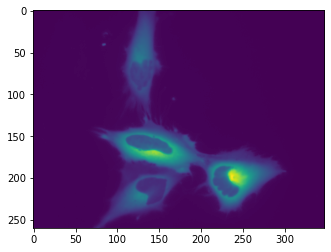

In [46]:
# Plot z-projections
plt.imshow(z_project_donor)
plt.show()

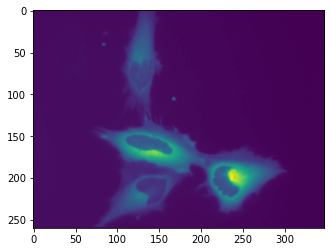

In [47]:
plt.imshow(z_project_acceptor)
plt.show()

## Extract background mask (region with no cell(s))
Refer to Tutorial 2 for steps to create mask of region of interest (ROI)

In [14]:
# Start coding here

viewer = napari.Viewer()
viewer.add_image(z_project_donor, name='Donor Channel')
viewer.add_image(z_project_acceptor, name='Acceptor Channel')

<Image layer 'Acceptor Channel' at 0x129d2a065e0>

In [65]:
# viewer.add_shapes(name='Background Mask')
background_mask = viewer.layers['napari_fx'].data
# End coding here

## Calculate average background intensity and also the standard deviation for all time frames and both channels. Plot them vs time.

In [66]:
from skimage.draw import polygon

image_shape = z_project_donor.shape
background_mask_bool = np.zeros(image_shape, dtype=bool)

for shape in background_mask:
    rr, cc = polygon(shape[:, 0].astype(int), shape[:, 1].astype(int), shape=image_shape)
    background_mask_bool[rr, cc] = True

In [67]:
background_donor = z_project_donor[background_mask_bool]
background_acceptor = z_project_acceptor[background_mask_bool]

In [68]:
# Mean and std dev calculation
# Start coding here

mean_donor = np.mean(donor_channel[:, background_mask_bool], axis=1)
mean_acceptor = np.mean(acceptor_channel[:, background_mask_bool], axis=1)
stddev_donor = np.std(donor_channel[:, background_mask_bool], axis=1)
stddev_acceptor = np.std(acceptor_channel[:, background_mask_bool], axis=1)

# End coding here

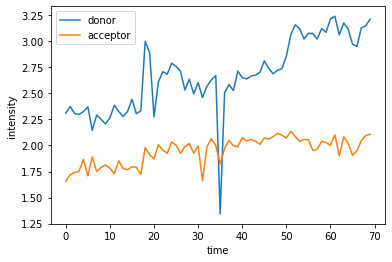

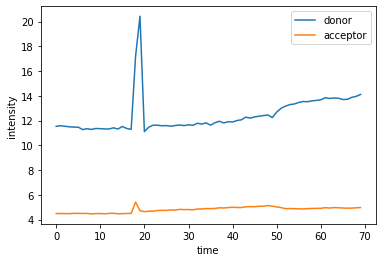

In [69]:
#Plotting 
plt.plot(mean_donor,label='donor')
plt.plot(mean_acceptor,label='acceptor')
# Set the labels
plt.xlabel('time')
plt.ylabel('intensity')
# Set the legend
plt.legend()
plt.show()
plt.close()

plt.plot(stddev_donor,label='donor')
plt.plot(stddev_acceptor,label='acceptor')
plt.xlabel('time')
plt.ylabel('intensity')

# Set the legend
plt.legend()
plt.show()

## Image processing steps

In [70]:
#Initializing parameters

# Define a smoothing kernel
ks = (3,3) # kernel size should be a tuple
kernel = np.ones(ks) / np.prod(ks) # create box filter kernel

# Initialize output array
corrected_frames = np.zeros_like(image,dtype=np.float64)

In [71]:
#Preparing the image data
# Convert pixel type to float
image = image.astype(np.float64)

# Channels extraction
donor_channel = image[:,0,:,:]
acceptor_channel = image[:,1,:,:]

In [72]:
#Now they begin - image processing

for t in range(image.shape[0]):

    #######################################
    ##Background subtraction
    #Start coding here
    donor_channel[t, :, :] -= mean_donor[t]
    acceptor_channel[t, :, :] -= mean_acceptor[t]

    #######################################
    ##Image registration
    #Calculate the shift between the two images
    shift, error, diffphase = phase_cross_correlation(donor_channel[t, :, :], acceptor_channel[t, :, :])

    #Create an affine transform object with the shift
    tform = AffineTransform(translation=(-shift[0], -shift[1]))

    #Apply the transformation to the image
    corrected_image = warp(acceptor_channel[t, :, :], tform.inverse)

    # Replace the original channel with the corrected channel
    acceptor_channel[t, :, :] = corrected_image

    #######################################
    ##Image processing steps to reduce noise
    ##Smoothing (hint: use the created kernel)
    donor_channel[t, :, :] = gaussian(donor_channel[t, :, :], sigma=1)
    acceptor_channel[t, :, :] = gaussian(acceptor_channel[t, :, :], sigma=1)

    #Thresholding so that pixels with low signal are assigned with np.nan.
    #Use the background mean and standard deviation intensity in this step to form a threshold value
    donor_channel[t, :, :] = img_as_float(donor_channel[t, :, :])
    acceptor_channel[t, :, :] = img_as_float(acceptor_channel[t, :, :])
    donor_channel[t, :, :][donor_channel[t, :, :] < mean_donor[t] + 2*stddev_donor[t]] = np.nan
    acceptor_channel[t, :, :][acceptor_channel[t, :, :] < mean_acceptor[t] + 2*stddev_acceptor[t]] = np.nan

    #Well done. Let's keep the corrected frames
    corrected_frames[t, 1, :, :] = acceptor_channel[t, :, :]
    corrected_frames[t, 0, :, :] = donor_channel[t, :, :]
    print(f'{t+1} of {image.shape[0]}')


    # End coding here

1 of 70
2 of 70
3 of 70
4 of 70
5 of 70
6 of 70
7 of 70
8 of 70
9 of 70
10 of 70
11 of 70
12 of 70
13 of 70
14 of 70
15 of 70
16 of 70
17 of 70
18 of 70
19 of 70
20 of 70
21 of 70
22 of 70
23 of 70
24 of 70
25 of 70
26 of 70
27 of 70
28 of 70
29 of 70
30 of 70
31 of 70
32 of 70
33 of 70
34 of 70
35 of 70
36 of 70
37 of 70
38 of 70
39 of 70
40 of 70
41 of 70
42 of 70
43 of 70
44 of 70
45 of 70
46 of 70
47 of 70
48 of 70
49 of 70
50 of 70
51 of 70
52 of 70
53 of 70
54 of 70
55 of 70
56 of 70
57 of 70
58 of 70
59 of 70
60 of 70
61 of 70
62 of 70
63 of 70
64 of 70
65 of 70
66 of 70
67 of 70
68 of 70
69 of 70
70 of 70


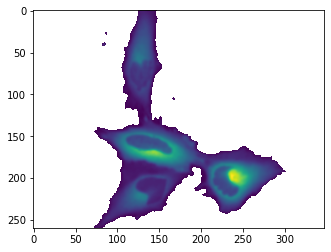

In [73]:
#Plotting
plt.imshow(corrected_frames[12, 0,:,:])
plt.show()

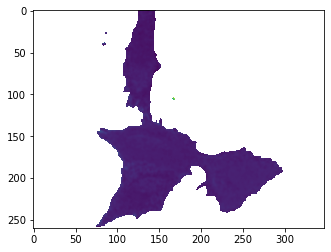

In [74]:
# Calculate FRET ratios. R = Acceptor/Donor
# Start coding here
ratio = corrected_frames[:, 1, :, :] / corrected_frames[:, 0, :, :]
# End coding here

#Plot a layer
plt.imshow(ratio[12,:,:])
plt.show()

In [78]:
# Export the FRET ratios images as an animated gif 
# Start coding here
with imageio.get_writer("fret_is_mid.gif", mode="I") as writer:
    for i in range(ratio.shape[0]):
        ratio_lul = img_as_ubyte(ratio[i])
        writer.append_data(ratio_lul)
# End coding here